<a href="https://colab.research.google.com/github/CarolineTomasik/AANN-Final/blob/main/AANN_Final_extensive_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from PIL import Image
import sklearn
import xgboost as xgb
from xgboost import plot_importance
import sklearn.ensemble
import sklearn.model_selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from datetime import datetime
from datetime import date
from numpy.random import seed
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import explained_variance_score, mean_squared_error
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import torch.nn as nn
from scipy import stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv('/listings2.csv', skiprows=[31041])

In [4]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,109,https://www.airbnb.com/rooms/109,20210407173820,2021-04-09,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",NaN,https://a0.muscache.com/pictures/4321499/1da98...,521,https://www.airbnb.com/users/show/521,Paolo,2008-06-27,"San Francisco, California, United States","Paolo Privitera, CEO Evensi\n\nPaolo, MIT MBA ...",within a day,100%,NaN,f,https://a0.muscache.com/im/pictures/user/e704a...,https://a0.muscache.com/im/pictures/user/e704a...,Culver City,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,NaN,Culver City,Other Cities,33.98301,-118.38607,Entire condominium,Entire home/apt,6,NaN,2 baths,2.0,3.0,"[""Free parking on premises"", ""Pool"", ""Kitchen""...",$115.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,0,0,0,0,2021-04-09,2,0,0,2011-08-15,2016-05-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,NaN,f,1,1,0,0,0.02
1,2708,https://www.airbnb.com/rooms/2708,20210407173820,2021-04-08,Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...,Run Runyon Canyon<br /><br />Beautifully Furni...,"Walk and run to Runyon Canyon, it is open!<br ...",https://a0.muscache.com/pictures/miso/Hosting-...,3008,https://www.airbnb.com/users/show/3008,Chas.,2008-09-16,"Los Angeles, California, United States",Writer.\r\nLiterary Manager.\r\nPhotographer.\...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/d17cf...,https://a0.muscache.com/im/pictures/user/d17cf...,Hollywood,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Los Angeles, California, United States",Hollywood,City of Los Angeles,34.09625,-118.34605,Private room in apartment,Private room,1,NaN,1.5 baths,1.0,1.0,"[""Free parking on premises"", ""Patio or balcony...",$78.00,30,366,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,5,9,26,301,2021-04-08,29,5,0,2014-06-09,2021-02-21,97.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,t,2,0,2,0,0.35
2,2732,https://www.airbnb.com/rooms/2732,20210407173820,2021-04-08,Zen Life at the Beach,An oasis of tranquility awaits you.<br /><br /...,"This is the best part of Santa Monica. Quiet, ...",https://a0.muscache.com/pictures/1082974/0f74c...,3041,https://www.airbnb.com/users/show/3041,Yoga Priestess,2008-09-17,"Santa Monica, California, United States",I have been teaching yoga and meditation for 3...,within an hour,100%,32%,f,https://a0.muscache.com/im/users/3041/profile_...,https://a0.muscache.com/im/users/3041/profile_...,Santa Monica,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Santa Monica, California, United States",Santa Monica,Other Cities,34.00440,-118.48095,Private room in apartment,Private room,1,NaN,1 private bath,1.0,1.0,"[""Heating"", ""Long term stays allo

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31542 entries, 0 to 31541
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            31542 non-null  int64  
 1   listing_url                                   31542 non-null  object 
 2   scrape_id                                     31542 non-null  int64  
 3   last_scraped                                  31542 non-null  object 
 4   name                                          31540 non-null  object 
 5   description                                   30431 non-null  object 
 6   neighborhood_overview                         19611 non-null  object 
 7   picture_url                                   31542 non-null  object 
 8   host_id                                       31542 non-null  int64  
 9   host_url                                      31542 non-null 

In [6]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)

**Data Cleaning**

In [7]:
df.isnull().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
name                                                2
description                                      1111
neighborhood_overview                           11931
picture_url                                         0
host_id                                             0
host_url                                            0
host_name                                        1167
host_since                                       1167
host_location                                    1239
host_about                                      13435
host_response_time                               9409
host_response_rate                               9409
host_acceptance_rate                             8774
host_is_superhost                                1167
host_thumbnail_url          

In [8]:
# dropping because column contains too many null values
df = df.drop(['bathrooms', 'calendar_updated', 'license'], axis=1)

#dropping because column is uninformative or very similar to another column
df = df.drop(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview','host_thumbnail_url', 'listing_url', 'host_picture_url', 'picture_url', 'host_listings_count', 'host_verifications',
              'host_id', 'host_url', 'host_name','host_location', 'host_about', 'host_neighbourhood', 'neighbourhood', 'bathrooms_text', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 
              'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'calendar_last_scraped',
              'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month'], axis=1)

**Price, this will be target variable**

Price outliers will be removed

In [9]:
df["price"] = df["price"].str.replace('$', '').str.replace(',', '').astype('float')
df = df[(np.abs(stats.zscore(df['price'])) < 3)]

**Change boolean features to binaries**

In [10]:
df.replace({'f': 0, 't': 1}, inplace=True)

**Examining distribution of features**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfba61e410>,
      dtype=object)

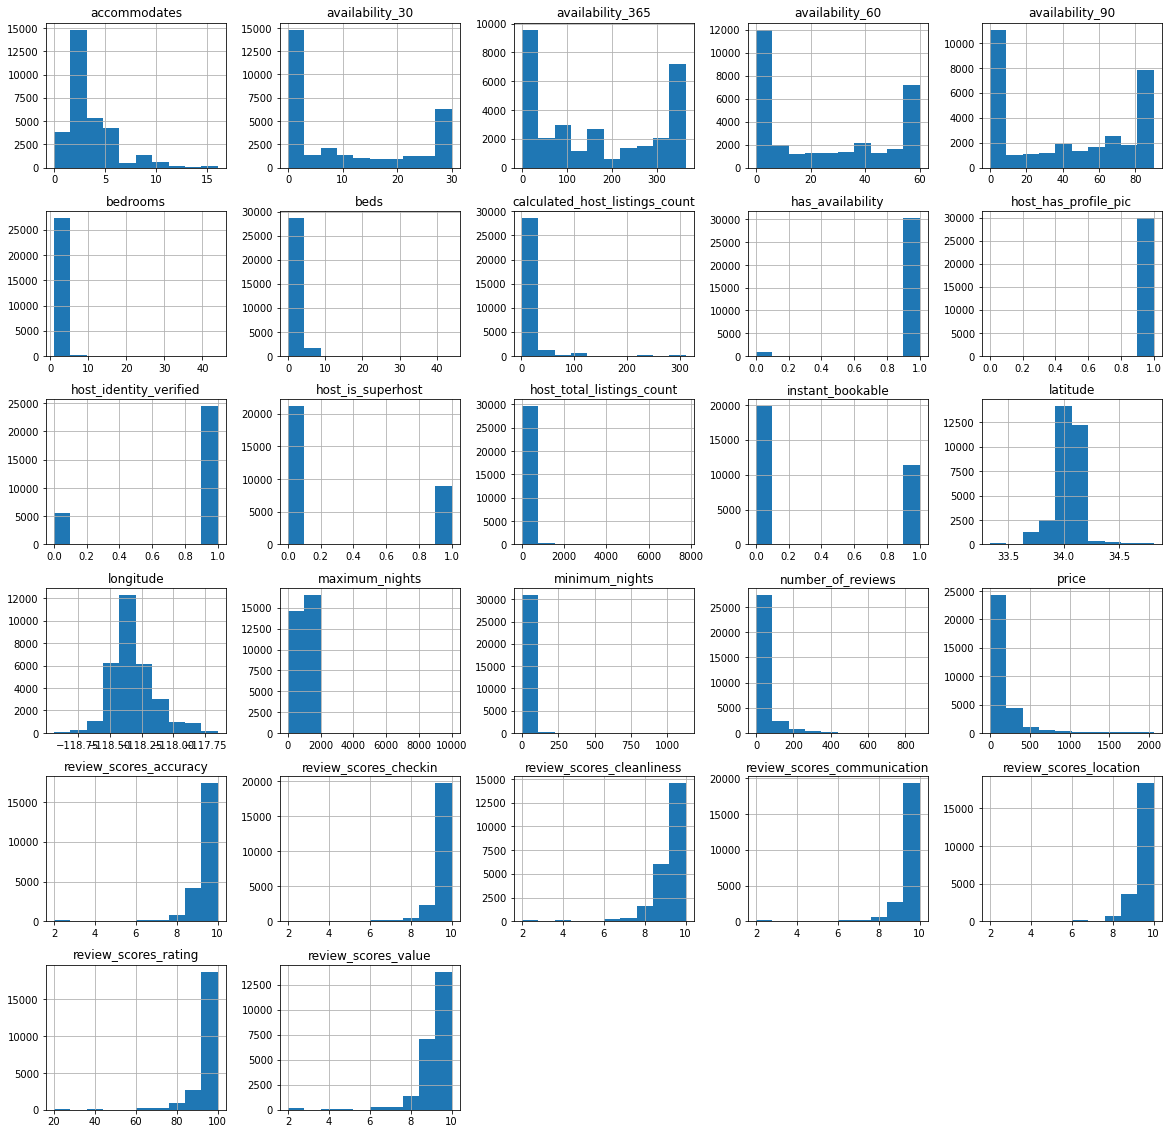

In [11]:
df.hist(figsize=(20,20))

In [12]:
df.host_has_profile_pic.value_counts()

1.0    29942
0.0       94
Name: host_has_profile_pic, dtype: int64

In [13]:
#dropping because has is highly skewed and provides little information
df.drop(['host_has_profile_pic'], axis=1, inplace=True)

**Converting longitude and latitude**

In [14]:
df['x'] = np.cos(df['latitude'], dtype=np.float64) * np.cos(df['longitude'], dtype=np.float64)
df['y'] = np.cos(df['latitude'], dtype=np.float64) * np.sin(df['longitude'], dtype=np.float64)
df['z'] = np.sin(df['latitude'], dtype=np.float64)
df.drop(['latitude', 'longitude'], axis=1, inplace=True)

**Converting host_since, first_review, and last_review from datetime to integer**

In [15]:
df.host_since = pd.to_datetime(df.host_since)
df['host_days_active'] = (datetime(2021, 4, 8) - df.host_since).astype('timedelta64[D]')
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

df.first_review = pd.to_datetime(df.first_review)
df['time_since_first_review'] = (datetime(2021, 4, 8) - df.first_review).astype('timedelta64[D]')
df.time_since_first_review.fillna(df.time_since_first_review.median(), inplace=True)

df.last_review = pd.to_datetime(df.last_review)
df['time_since_last_review'] = (datetime(2021, 4, 8) - df.last_review).astype('timedelta64[D]')
df.time_since_last_review.fillna(df.time_since_last_review.median(), inplace=True)

df.drop(['host_since', 'first_review', 'last_review'], axis=1, inplace=True)

**host response time**

In [16]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

within an hour        0.463829
unknown               0.299016
within a few hours    0.125677
within a day          0.074778
a few days or more    0.036700
Name: host_response_time, dtype: float64

**host response rate**

In [17]:
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype('float')
df.host_response_rate.fillna(df['host_response_rate'].median(), inplace=True)
df.host_response_rate.describe()

count    31199.000000
mean        94.254688
std         18.010315
min          0.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: host_response_rate, dtype: float64

**Host acceptance rate**

In [18]:
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '').astype('float')
df.host_acceptance_rate.fillna(df['host_acceptance_rate'].median(), inplace=True)
df.host_acceptance_rate.describe()

count    31199.000000
mean        85.796436
std         23.779846
min          0.000000
25%         88.000000
50%         95.000000
75%         99.000000
max        100.000000
Name: host_acceptance_rate, dtype: float64

**property type**

In [19]:
df.property_type.value_counts()

Entire apartment                      7863
Entire house                          5310
Private room in house                 4511
Private room in apartment             2257
Entire guesthouse                     1717
Entire condominium                    1395
Entire guest suite                    1033
Entire serviced apartment              797
Private room in condominium            562
Entire bungalow                        560
Shared room in house                   548
Private room in townhouse              500
Entire townhouse                       490
Entire loft                            417
Room in boutique hotel                 378
Entire villa                           314
Shared room in apartment               295
Private room in villa                  291
Private room in guest suite            288
Room in hotel                          215
Private room in bungalow               213
Entire cottage                         150
Private room in guesthouse             117
Private roo

In [20]:
df.property_type.replace({
    'Entire house': 'House',
    'Private room in house': 'Private Room',
    'Private room in apartment': 'Private Room',
    'Private room in condominium': 'Private Room',
    'Private room in townhouse': 'Private Room',
    'Private room in villa': 'Private Room',
    'Private room in guest suite': 'Private Room',
    'Private room in guesthouse': 'Private Room',
    'Private room in bed and breakfast': 'Private Room',
    'Private room in loft': 'Private Room',
    'Private room': 'Private Room',
    'Private room in cottage': 'Private Room',
    'Private room': 'Private Room',
    'Private room in tiny house': 'Private Room',
    'Private room in serviced apartment': 'Private Room',
    'Private room in bungalow': 'Private Room',
    'Private room in cabin': 'Private Room',
    'Entire guest suite': 'House',
    'Entire guesthouse': 'House',
    'Entire condominium': 'House',
    'Townhouse': 'House',
    'Entire apartment': 'Apartment',
    'Entire serviced apartment': 'Apartment',
    'Entire loft': 'Apartment',
    'Entire bungalow': 'House',
    'Entire townhouse': 'House',
    'Entire villa': 'House',
    'Entire cottage': 'House',
    'Entire cabin': 'House',
    'Tiny house': 'House' 
    }, inplace=True)

df.loc[~df.property_type.isin(['House', 'Apartment', 'Private Room']), 'property_type'] = 'Other'
df.property_type.value_counts()

House           11076
Apartment        9077
Private Room     8996
Other            2050
Name: property_type, dtype: int64

**amenities**

In [21]:
df.amenities.fillna("None", inplace=True)
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [22]:
infrequent_amenities = []
for col in df.iloc[:,37:].columns:
    if df[col].sum().astype(float) < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

df.drop(infrequent_amenities, axis=1, inplace=True)
df.drop('amenities', axis=1, inplace=True)

cols = df.iloc[:,37:].columns
df[cols] = df[cols].fillna(0)

['check_in_24h', 'high_end_electronics', 'nature_and_views', 'breakfast', 'child_friendly', 'outdoor_space', 'pets_allowed', 'secure', 'self_check_in', 'smoking_allowed', 'accessible', 'event_suitable']


**Imputation**

In [23]:
df.isna().sum()

host_response_time                   0
host_response_rate                   0
host_acceptance_rate                 0
host_is_superhost                 1163
host_total_listings_count         1163
host_identity_verified            1163
neighbourhood_cleansed               0
neighbourhood_group_cleansed         0
property_type                        0
room_type                            0
accommodates                         0
bedrooms                          3697
beds                               732
price                                0
minimum_nights                       0
maximum_nights                       0
has_availability                     0
availability_30                      0
availability_60                      0
availability_90                      0
availability_365                     0
number_of_reviews                    0
review_scores_rating              7974
review_scores_accuracy            8165
review_scores_cleanliness         8164
review_scores_checkin    

In [24]:
df = df[df['host_is_superhost'].notna()]

from sklearn.impute import SimpleImputer 
imputer=SimpleImputer(missing_values=np.nan,strategy='median')

imputer=imputer.fit(df.loc[:,'review_scores_rating':'review_scores_value'])
df.loc[:,'review_scores_rating':'review_scores_value']=imputer.transform(df.loc[:,'review_scores_rating':'review_scores_value'])

imputer=imputer.fit(df.loc[:,'bedrooms':'beds'])
df.loc[:,'bedrooms':'beds']=imputer.transform(df.loc[:,'bedrooms':'beds'])

**Examining multicollinearity**

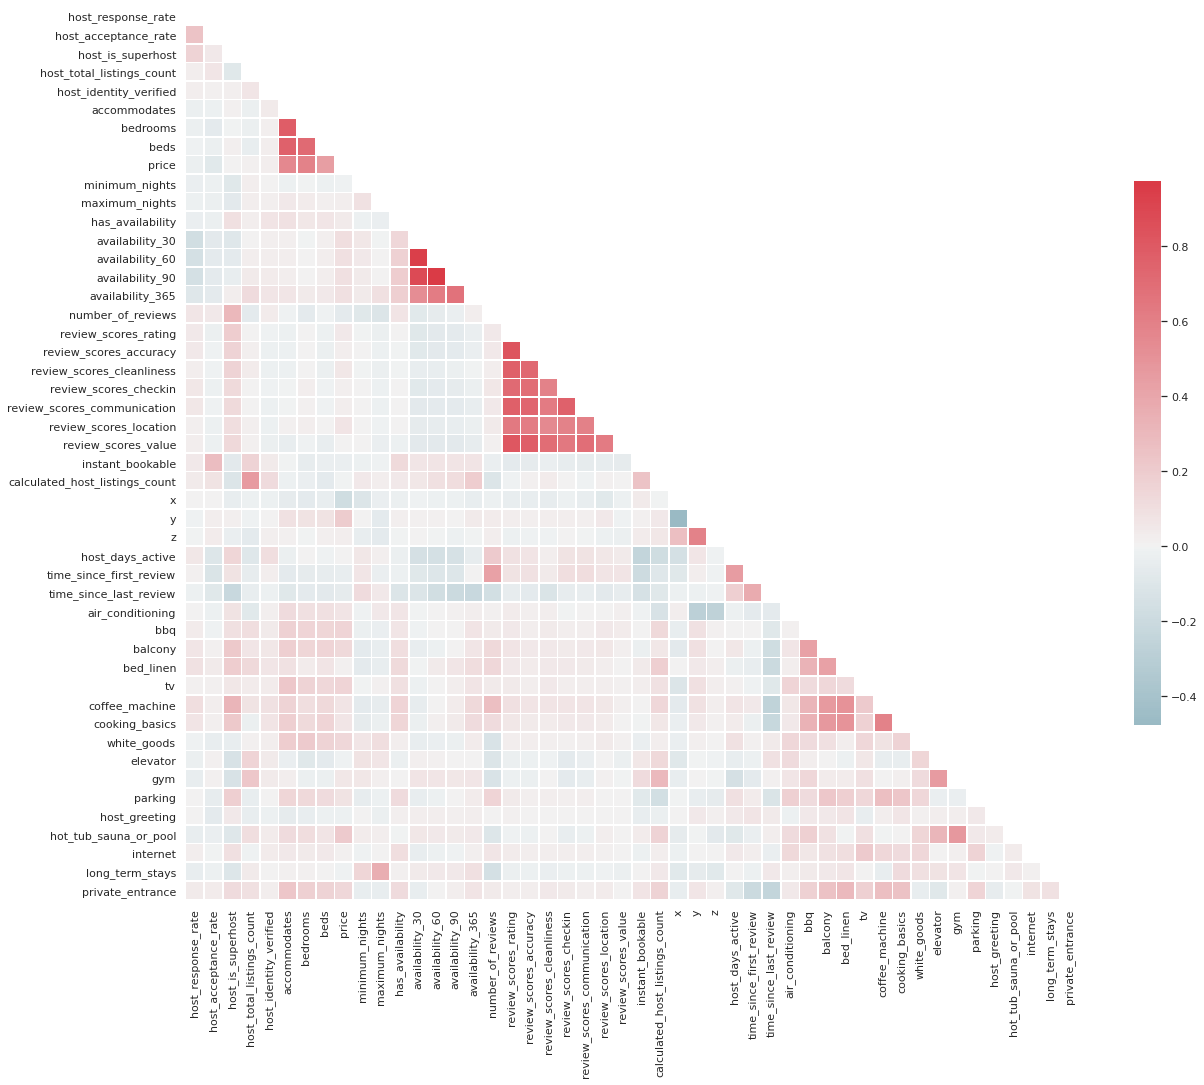

In [25]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    sns.set(style="white")
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max())
    
multi_collinearity_heatmap(df, figsize=(20,20))

Dropping collinear features; keeping various review scores because even though a high review score in one area is correlated with a high review score in another, may still be useful to see which review category is the most influential.

In [26]:
df.drop(['beds', 'bedrooms', 'availability_60', 'availability_90', 'calculated_host_listings_count', 'has_availability'], axis=1, inplace=True)

**Creating one-hot encodings**

In [27]:
df = pd.get_dummies(df, prefix=['hrt', 'nc', 'ngc', 'rt', 'pt'], columns=['host_response_time', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'room_type', 'property_type'], drop_first=True)

In [28]:
df.describe()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,accommodates,price,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,x,y,z,host_days_active,time_since_first_review,time_since_last_review,air_conditioning,bbq,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,parking,host_greeting,hot_tub_sauna_or_pool,internet,...,nc_Van Nuys,nc_Venice,nc_Vermont Knolls,nc_Vermont Square,nc_Vermont Vista,nc_Vermont-Slauson,nc_Vernon,nc_Veterans Administration,nc_View Park-Windsor Hills,nc_Vincent,nc_Walnut,nc_Watts,nc_West Adams,nc_West Carson,nc_West Compton,nc_West Covina,nc_West Hills,nc_West Hollywood,nc_West Los Angeles,nc_West Puente Valley,nc_West Whittier-Los Nietos,nc_Westchester,nc_Westlake,nc_Westlake Village,nc_Westmont,nc_Westwood,nc_Whittier,nc_Willowbrook,nc_Wilmington,nc_Windsor Square,nc_Winnetka,nc_Woodland Hills,ngc_Other Cities,ngc_Unincorporated Areas,rt_Hotel room,rt_Private room,rt_Shared room,pt_House,pt_Other,pt_Private Room
count,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,...,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000,30036.000000
mean,94.032228,85.440072,0.297143,40.991011,0.812991,3.474364,181.278932,19.844520,662.799074,10.402783,162.443801,33.864263,95.124650,9.713877,9.576708,9.823645,9.799208,9.782694,9.571814,0.367692,-0.414506,-0.745590,0.484337,1822.721068,1018.691870,303.484718,0.770142,0.164203,0.351944,0.461380,0.838560,0.523239,0.510787,0.781396,0.150886,0.140631,0.847150,0.127913,0.266613,0.973665,...,0.006426,0.049074,0.000799,0.001931,0.000233,0.000599,0.000067,0.000599,0.002464,0.000133,0.002331,0.000866,0.002663,0.001165,0.000166,0.004528,0.002031,0.020942,0.005294,0.000266,0.000233,0.006858,0.014816,0.000166,0.000999,0.014483,0.001964,0.000566,0.000999,0.000832,0.002064,0.008124,0.362465,0.079172,0.004594,0.308796,0.032528,0.354108,0.065455,0.289319
std,18.319497,24.165480,0.457008,274.561042,0.389925,2.405610,230.852846,33.491353,505.785253,11.919073,141.713553,66.529499,8.346068,0.839968,0.935942,0.707891,0.755029,0.678001,0.908208,0.482185,0.135122,0.082614,0.112323,935.969149,668.900795,406.172840,0.420748,0.370466,0.477585,0.498515,0.367942,0.499468,0.499892,0.413306,0.357943,0.347647,0.359849,0.333999,0.442196,0.160132,...,0.079903,0.216027,0.028256,0.043902,0.015265,0.024473,0.008160,0.024473,0.049575,0.011540,0.048220,0.029409,0.051541,0.034117,0.012901,0.067138,0.045020,0.143191,0.072566,0.016318,0.015265,0.082533,0.120816,0.012901,0.031589,0.119471,0.044278,0.023784,0.031589,0.028839,0.045387,0.089766,0.480720,0.270011,0.067628,0.462005,0.177400,0.478250,0.247331,0.453454
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,-0.787247,-0.998370,-0.

In [29]:
df.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,accommodates,price,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,x,y,z,host_days_active,time_since_first_review,time_since_last_review,air_conditioning,bbq,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,parking,host_greeting,hot_tub_sauna_or_pool,internet,...,nc_Van Nuys,nc_Venice,nc_Vermont Knolls,nc_Vermont Square,nc_Vermont Vista,nc_Vermont-Slauson,nc_Vernon,nc_Veterans Administration,nc_View Park-Windsor Hills,nc_Vincent,nc_Walnut,nc_Watts,nc_West Adams,nc_West Carson,nc_West Compton,nc_West Covina,nc_West Hills,nc_West Hollywood,nc_West Los Angeles,nc_West Puente Valley,nc_West Whittier-Los Nietos,nc_Westchester,nc_Westlake,nc_Westlake Village,nc_Westmont,nc_Westwood,nc_Whittier,nc_Willowbrook,nc_Wilmington,nc_Windsor Square,nc_Winnetka,nc_Woodland Hills,ngc_Other Cities,ngc_Unincorporated Areas,rt_Hotel room,rt_Private room,rt_Shared room,pt_House,pt_Other,pt_Private Room
0,100.0,95.0,0.0,1.0,1.0,6,115.0,30,730,0,0,2,80.0,10.0,10.0,6.0,8.0,10.0,8.0,0,-0.457475,-0.703853,0.543423,4668.0,3524.0,1789.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,100.0,100.0,1.0,2.0,1.0,1,78.0,30,366,5,301,29,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,-0.457577,-0.769755,0.445085,4587.0,2495.0,46.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,100.0,32.0,0.0,2.0,1.0,1,155.0,1,180,0,335,21,94.0,9.0,9.0,9.0,9.0,10.0,9.0,0,-0.529208,-0.666298,0.525344,4586.0,3594.0,468.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
3,100.0,95.0,0.0,1.0,1.0,2,50.0,30,730,0,0,0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,-0.233319,-0.740013,0.630827,4578.0,921.0,159.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,100.0,0.0,0.0,6.0,1.0,2,118.0,31,730,30,365,23,81.0,8.0,8.0,8.0,9.0,9.0,8.0,0,-0.488765,-0.758353,0.431287,4571.0,2774.0,890.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


**Defining X and y and scaling**

In [30]:
scaler = MinMaxScaler()

X = df.drop('price', axis=1)
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
X.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,accommodates,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,x,y,z,host_days_active,time_since_first_review,time_since_last_review,air_conditioning,bbq,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,parking,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,...,nc_Van Nuys,nc_Venice,nc_Vermont Knolls,nc_Vermont Square,nc_Vermont Vista,nc_Vermont-Slauson,nc_Vernon,nc_Veterans Administration,nc_View Park-Windsor Hills,nc_Vincent,nc_Walnut,nc_Watts,nc_West Adams,nc_West Carson,nc_West Compton,nc_West Covina,nc_West Hills,nc_West Hollywood,nc_West Los Angeles,nc_West Puente Valley,nc_West Whittier-Los Nietos,nc_Westchester,nc_Westlake,nc_Westlake Village,nc_Westmont,nc_Westwood,nc_Whittier,nc_Willowbrook,nc_Wilmington,nc_Windsor Square,nc_Winnetka,nc_Woodland Hills,ngc_Other Cities,ngc_Unincorporated Areas,rt_Hotel room,rt_Private room,rt_Shared room,pt_House,pt_Other,pt_Private Room
0,1.0,0.95,0.0,0.000129,1.0,0.3750,0.025801,0.199781,0.000000,0.000000,0.002281,0.7500,1.000,1.000,0.500,0.750,1.000,0.750,0.0,0.351151,0.421490,0.667717,1.000000,0.812961,0.444582,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1.00,1.0,0.000258,1.0,0.0625,0.025801,0.100027,0.166667,0.824658,0.033067,0.9625,1.000,1.000,1.000,1.000,1.000,1.000,1.0,0.351042,0.327177,0.585053,0.982640,0.575646,0.012398,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.32,0.0,0.000258,1.0,0.0625,0.000000,0.049055,0.000000,0.917808,0.023945,0.9250,0.875,0.875,0.875,0.875,1.000,0.875,0.0,0.274768,0.475236,0.652520,0.982426,0.829105,0.117034,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.95,0.0,0.000129,1.0,0.1250,0.025801,0.199781,0.000000,0.000000,0.000000,0.9625,1.000,1.000,1.000,1.000,1.000,1.000,1.0,0.589838,0.369741,0.741190,0.980712,0.212638,0.040417,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.00,0.0,0.000774,1.0,0.1250,0.026690,0.199781,1.000000,1.000000,0.026226,0.7625,0.750,0.750,0.750,0.875,0.875,0.750,0.0,0.317832,0.343494,0.573455,0.979211,0.639991,0.221671,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [31]:
y = df[['price']]
y = pd.DataFrame(scaler.fit_transform(y), columns=list(y.columns))
y.head()

,price
0,0.055907
1,0.037919
2,0.075352
3,0.024307
4,0.057365


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

**Machine Learning Models**

**Linear Regression**

In [33]:
linreg = LinearRegression()
linreg.fit(X_train,y_train)
training_preds_linreg = linreg.predict(X_train)
val_preds_linreg = linreg.predict(X_test)

print('Linear Regression Explained Variance Score:', round(explained_variance_score(y_test, val_preds_linreg),3))
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_linreg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_linreg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_linreg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_linreg),4))

Linear Regression Explained Variance Score: -2.5144998659358597e+19

Training MSE: 0.0062
Validation MSE: 3.415681588048515e+17

Training r2: 0.4958
Validation r2: -2.5157560109265404e+19


**Random Forest**

In [34]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=30, random_state=0)
rf.fit(X_train, y_train.values.ravel())
training_preds_rf = rf.predict(X_train)
val_preds_rf = rf.predict(X_test)

print('Random Forest Explained Variance Score:', round(explained_variance_score(y_test, val_preds_rf),3))
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_rf),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_rf),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_rf),4))
print("Validation r2:", round(r2_score(y_test, val_preds_rf),4))

Random Forest Explained Variance Score: 0.582

Training MSE: 0.0007
Validation MSE: 0.0057

Training r2: 0.9432
Validation r2: 0.5819


**XGBoost**

In [35]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

print('XGB Explained Variance Score:', round(explained_variance_score(y_test, val_preds_xgb_reg),3))
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

XGB Explained Variance Score: 0.611

Training MSE: 0.0016
Validation MSE: 0.0053

Training r2: 0.8726
Validation r2: 0.6109


In [36]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg

,weight
hot_tub_sauna_or_pool,0.072066
pt_Private Room,0.062184
nc_Malibu,0.060371
accommodates,0.047885
nc_Hollywood Hills West,0.045082
pt_House,0.026036
nc_Beverly Grove,0.024495
nc_Pico-Robertson,0.024377
rt_Shared room,0.016943
ngc_Unincorporated Areas,0.015369


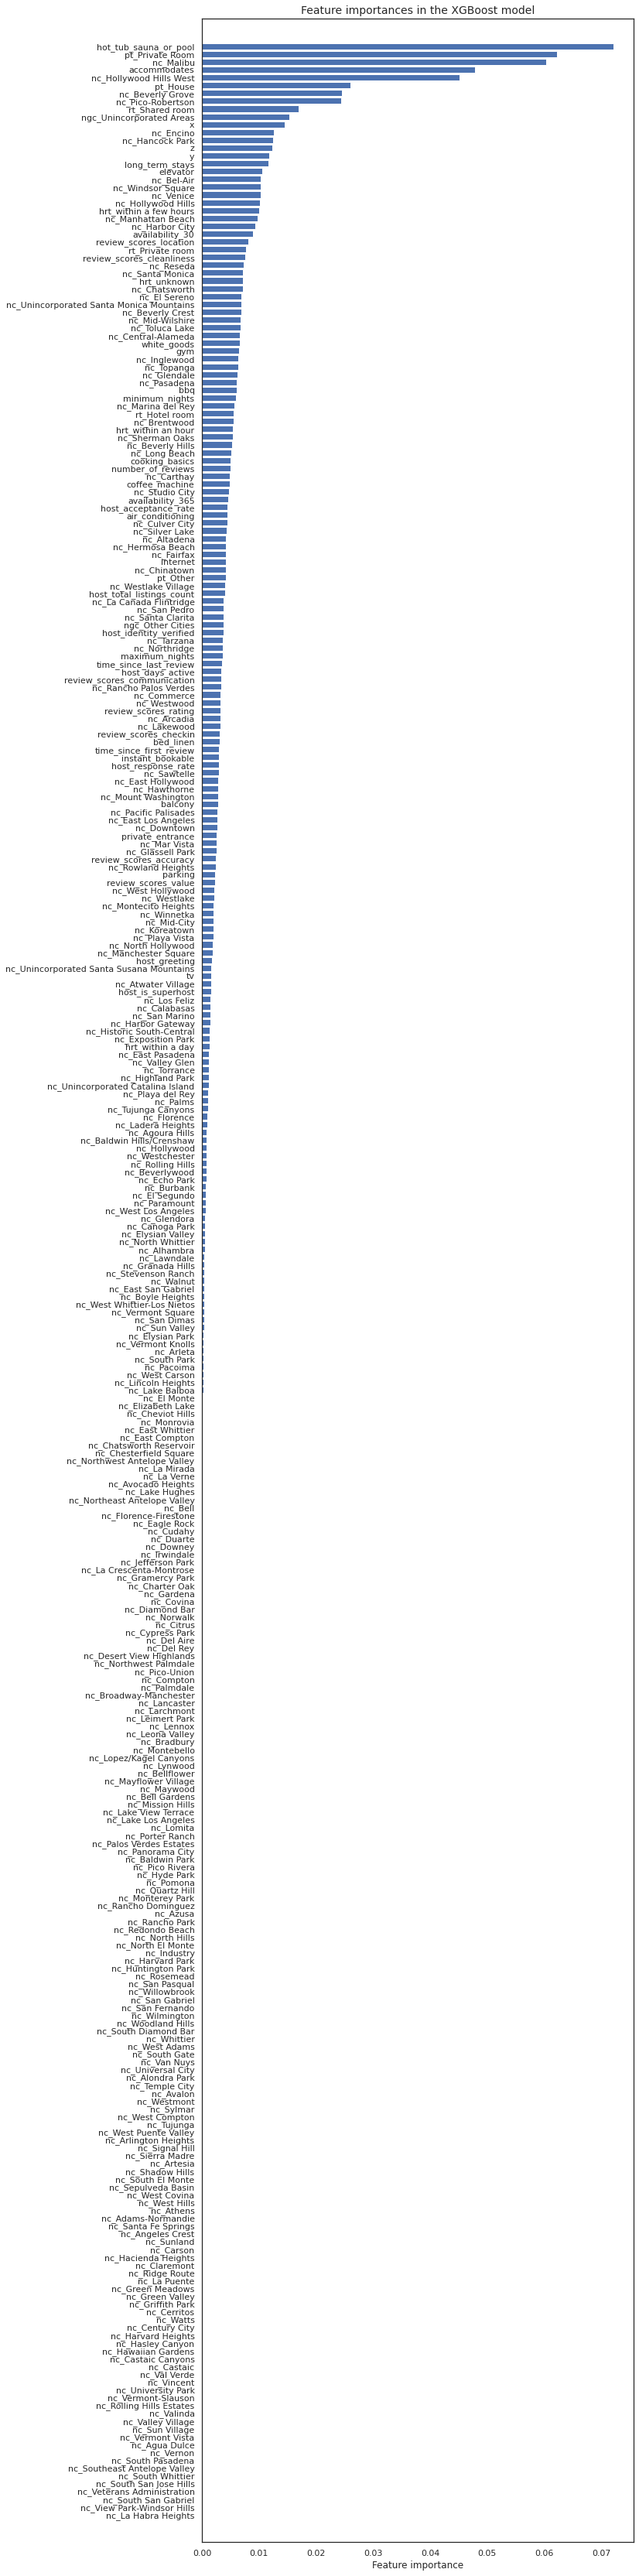

In [37]:
# Plotting feature importances
ft_weights_xgb_reg.sort_values('weight', inplace=True)
plt.figure(figsize=(10,60))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

**ANN Models**

In [38]:
scaler = MinMaxScaler()

X = df.drop('price', axis=1)
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

y = df[['price']]
y = pd.DataFrame(scaler.fit_transform(y), columns=list(y.columns))

In [39]:
dft = TensorDataset(torch.tensor(X.values, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32))
batch_size = 128

train_len = int(len(dft)*0.8)
val_len = len(dft) - train_len

train_ds, val_ds = random_split(dft, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

input_size = X.shape[1]
output_size = 1 #output is 1 because its a regression task


def evaluate(model, train_loader, val_loader):
    outputs_t = [model.validation_step(batch) for batch in train_loader]
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs_t, outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, train_loader, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 128)
        self.linear2 = nn.Linear(128, 64)
        self.drop = nn.Dropout(p=0.2)
        self.linear3 = nn.Linear(64, output_size)
        
    def forward(self, xb):
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.linear3(out)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                
        loss = F.mse_loss(out, targets) 
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)           
        loss = F.mse_loss(out, targets)    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs_t, outputs):
        batch_losses_t = [x['val_loss'] for x in outputs_t]
        epoch_loss_t = torch.stack(batch_losses_t).mean()
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() 
        return {'train_loss': epoch_loss_t.item(), 'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

**Model 1**

SGD optimizer, dropout = 0.2, 0.05 learning rate

In [40]:
model1 = Model()
evaluate(model1, train_loader, val_loader)
history1 = fit(100, 0.05, model1, train_loader, val_loader, opt_func=torch.optim.SGD)

Epoch [0], val_loss: 0.0111
Epoch [1], val_loss: 0.0101
Epoch [2], val_loss: 0.0095
Epoch [3], val_loss: 0.0091
Epoch [4], val_loss: 0.0087
Epoch [5], val_loss: 0.0084
Epoch [6], val_loss: 0.0081
Epoch [7], val_loss: 0.0078
Epoch [8], val_loss: 0.0076
Epoch [9], val_loss: 0.0074
Epoch [10], val_loss: 0.0071
Epoch [11], val_loss: 0.0069
Epoch [12], val_loss: 0.0068
Epoch [13], val_loss: 0.0066
Epoch [14], val_loss: 0.0065
Epoch [15], val_loss: 0.0064
Epoch [16], val_loss: 0.0062
Epoch [17], val_loss: 0.0062
Epoch [18], val_loss: 0.0061
Epoch [19], val_loss: 0.0059
Epoch [20], val_loss: 0.0058
Epoch [21], val_loss: 0.0056
Epoch [22], val_loss: 0.0056
Epoch [23], val_loss: 0.0055
Epoch [24], val_loss: 0.0056
Epoch [25], val_loss: 0.0055
Epoch [26], val_loss: 0.0054
Epoch [27], val_loss: 0.0054
Epoch [28], val_loss: 0.0054
Epoch [29], val_loss: 0.0053
Epoch [30], val_loss: 0.0053
Epoch [31], val_loss: 0.0052
Epoch [32], val_loss: 0.0052
Epoch [33], val_loss: 0.0052
Epoch [34], val_loss: 0.

In [41]:
result1 = evaluate(model1, train_loader, val_loader)
result1

{'train_loss': 0.004899441730231047, 'val_loss': 0.00474966736510396}

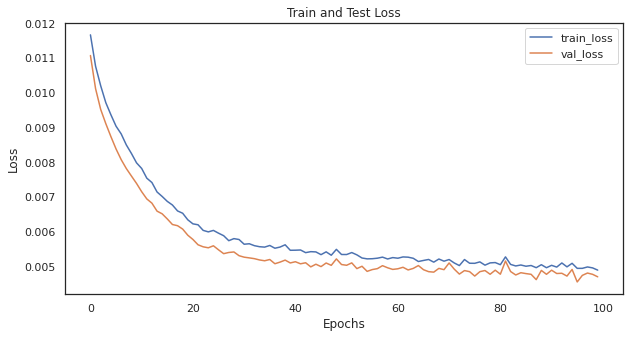

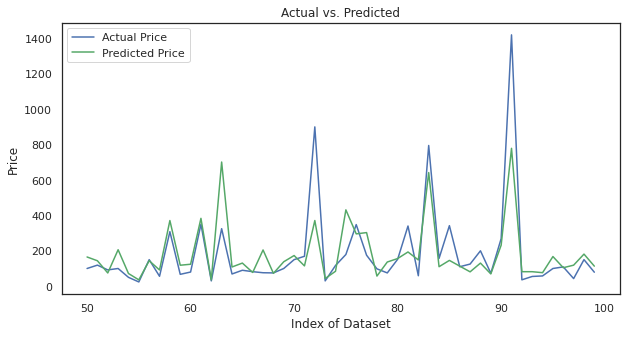

In [42]:
pd.DataFrame(history1).plot(figsize=(10,5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss")
plt.show()


def predict_single(x, model1):
    xb = x.unsqueeze(0)
    return model1(x).item()

# Predicting on 50 datapoints
tar = []
pre = []
for i in range(50, 100):
    x, target = val_ds[i]
    pred = predict_single(x, model1)
    # print("Input: ", x)
    data = scaler.inverse_transform(np.array([target.item(), pred]).reshape(-1, 1)).tolist()
    tar.append(data[0][0])
    pre.append(data[1][0])

x_axis = np.arange(50, 100, 1)
plt.figure(figsize=(10, 5))
plt.xlabel("Index of Dataset")
plt.ylabel("Price")
plt.title("Actual vs. Predicted")
plt.plot(x_axis, tar, 'b', label="Actual Price")
plt.plot(x_axis, pre, 'g', label="Predicted Price")
plt.legend()
plt.show()

**Model 2**

Adagrad optimizer, dropout = 0.2, 0.1 learning rate

In [43]:
batch_size = 128

model2 = Model()
evaluate(model2, train_loader, val_loader)
history2 = fit(100, 0.1, model2, train_loader, val_loader, opt_func=torch.optim.Adagrad)

Epoch [0], val_loss: 0.0088
Epoch [1], val_loss: 0.0081
Epoch [2], val_loss: 0.0079
Epoch [3], val_loss: 0.0074
Epoch [4], val_loss: 0.0068
Epoch [5], val_loss: 0.0067
Epoch [6], val_loss: 0.0065
Epoch [7], val_loss: 0.0063
Epoch [8], val_loss: 0.0061
Epoch [9], val_loss: 0.0061
Epoch [10], val_loss: 0.0057
Epoch [11], val_loss: 0.0057
Epoch [12], val_loss: 0.0056
Epoch [13], val_loss: 0.0059
Epoch [14], val_loss: 0.0055
Epoch [15], val_loss: 0.0056
Epoch [16], val_loss: 0.0053
Epoch [17], val_loss: 0.0055
Epoch [18], val_loss: 0.0055
Epoch [19], val_loss: 0.0055
Epoch [20], val_loss: 0.0055
Epoch [21], val_loss: 0.0055
Epoch [22], val_loss: 0.0054
Epoch [23], val_loss: 0.0055
Epoch [24], val_loss: 0.0054
Epoch [25], val_loss: 0.0053
Epoch [26], val_loss: 0.0052
Epoch [27], val_loss: 0.0053
Epoch [28], val_loss: 0.0056
Epoch [29], val_loss: 0.0055
Epoch [30], val_loss: 0.0055
Epoch [31], val_loss: 0.0052
Epoch [32], val_loss: 0.0053
Epoch [33], val_loss: 0.0054
Epoch [34], val_loss: 0.

In [44]:
result2 = evaluate(model2, train_loader, val_loader)
result2

{'train_loss': 0.00461104279384017, 'val_loss': 0.004932985175400972}

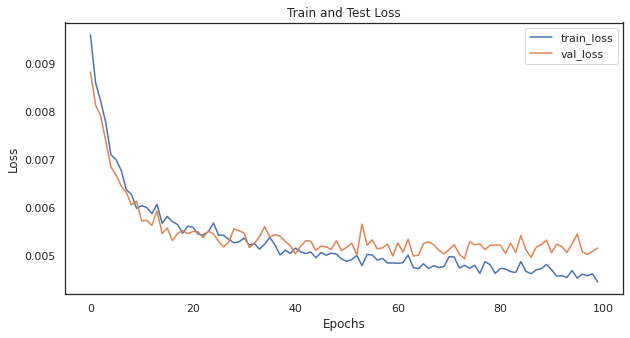

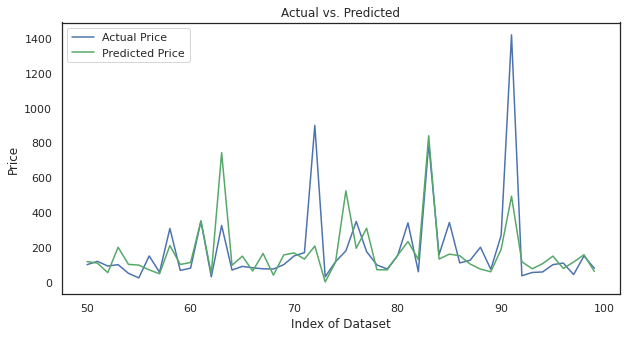

In [45]:
pd.DataFrame(history2).plot(figsize=(10,5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss")
plt.show()


def predict_single(x, model2):
    xb = x.unsqueeze(0)
    return model2(x).item()

# Predicting on 50 datapoints
tar = []
pre = []
for i in range(50, 100):
    x, target = val_ds[i]
    pred = predict_single(x, model2)
    # print("Input: ", x)
    data = scaler.inverse_transform(np.array([target.item(), pred]).reshape(-1, 1)).tolist()
    tar.append(data[0][0])
    pre.append(data[1][0])

x_axis = np.arange(50, 100, 1)
plt.figure(figsize=(10, 5))
plt.xlabel("Index of Dataset")
plt.ylabel("Price")
plt.title("Actual vs. Predicted")
plt.plot(x_axis, tar, 'b', label="Actual Price")
plt.plot(x_axis, pre, 'g', label="Predicted Price")
plt.legend()
plt.show()

**Model 3 with different architecture**

In [46]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.drop1 = nn.Dropout(p=0.2)
        self.linear3 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(p=0.2)
        self.linear4 = nn.Linear(64, output_size)
        
    def forward(self, xb):
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.drop1(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.drop2(out)
        out = self.linear4(out)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                
        loss = F.mse_loss(out, targets) 
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)           
        loss = F.mse_loss(out, targets)    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs_t, outputs):
        batch_losses_t = [x['val_loss'] for x in outputs_t]
        epoch_loss_t = torch.stack(batch_losses_t).mean()
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() 
        return {'train_loss': epoch_loss_t.item(), 'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

In [47]:
model3 = Model()
evaluate(model3, train_loader, val_loader)
history3 = fit(100, 0.05, model3, train_loader, val_loader, opt_func=torch.optim.Adagrad)

Epoch [0], val_loss: 0.0077
Epoch [1], val_loss: 0.0064
Epoch [2], val_loss: 0.0061
Epoch [3], val_loss: 0.0057
Epoch [4], val_loss: 0.0055
Epoch [5], val_loss: 0.0057
Epoch [6], val_loss: 0.0055
Epoch [7], val_loss: 0.0056
Epoch [8], val_loss: 0.0053
Epoch [9], val_loss: 0.0051
Epoch [10], val_loss: 0.0053
Epoch [11], val_loss: 0.0054
Epoch [12], val_loss: 0.0054
Epoch [13], val_loss: 0.0051
Epoch [14], val_loss: 0.0052
Epoch [15], val_loss: 0.0052
Epoch [16], val_loss: 0.0052
Epoch [17], val_loss: 0.0054
Epoch [18], val_loss: 0.0052
Epoch [19], val_loss: 0.0053
Epoch [20], val_loss: 0.0052
Epoch [21], val_loss: 0.0052
Epoch [22], val_loss: 0.0051
Epoch [23], val_loss: 0.0051
Epoch [24], val_loss: 0.0049
Epoch [25], val_loss: 0.0052
Epoch [26], val_loss: 0.0051
Epoch [27], val_loss: 0.0047
Epoch [28], val_loss: 0.0049
Epoch [29], val_loss: 0.0048
Epoch [30], val_loss: 0.0051
Epoch [31], val_loss: 0.0051
Epoch [32], val_loss: 0.0049
Epoch [33], val_loss: 0.0051
Epoch [34], val_loss: 0.

In [48]:
result3 = evaluate(model3, train_loader, val_loader)
result3

{'train_loss': 0.004081896506249905, 'val_loss': 0.004927444737404585}

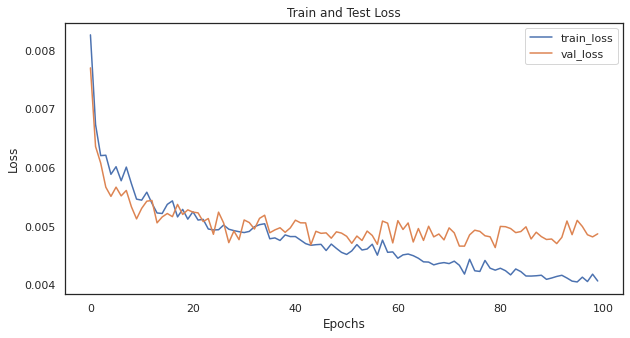

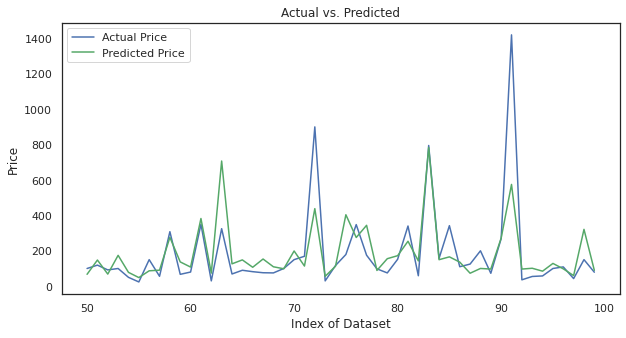

In [49]:
pd.DataFrame(history3).plot(figsize=(10,5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss")
plt.show()


def predict_single(x, model3):
    xb = x.unsqueeze(0)
    return model3(x).item()

# Predicting on 50 datapoints
tar = []
pre = []
for i in range(50, 100):
    x, target = val_ds[i]
    pred = predict_single(x, model3)
    # print("Input: ", x)
    data = scaler.inverse_transform(np.array([target.item(), pred]).reshape(-1, 1)).tolist()
    tar.append(data[0][0])
    pre.append(data[1][0])

x_axis = np.arange(50, 100, 1)
plt.figure(figsize=(10, 5))
plt.xlabel("Index of Dataset")
plt.ylabel("Price")
plt.title("Actual vs. Predicted")
plt.plot(x_axis, tar, 'b', label="Actual Price")
plt.plot(x_axis, pre, 'g', label="Predicted Price")
plt.legend()
plt.show()

Model 4

In [50]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.drop1 = nn.Dropout(p=0.2)
        self.linear3 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(p=0.2)
        self.linear4 = nn.Linear(64, output_size)
        
    def forward(self, xb):
        out = self.linear1(xb)
        out = torch.sigmoid(out)
        out = self.linear2(out)
        out = torch.sigmoid(out)
        out = self.drop1(out)
        out = self.linear3(out)
        out = torch.sigmoid(out)
        out = self.drop2(out)
        out = self.linear4(out)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                
        loss = F.mse_loss(out, targets) 
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)           
        loss = F.mse_loss(out, targets)    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs_t, outputs):
        batch_losses_t = [x['val_loss'] for x in outputs_t]
        epoch_loss_t = torch.stack(batch_losses_t).mean()
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() 
        return {'train_loss': epoch_loss_t.item(), 'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

In [51]:
model4 = Model()
evaluate(model4, train_loader, val_loader)
history4 = fit(100, 0.1, model4, train_loader, val_loader, opt_func=torch.optim.Adagrad)

Epoch [0], val_loss: 0.0139
Epoch [1], val_loss: 0.0126
Epoch [2], val_loss: 0.0124
Epoch [3], val_loss: 0.0119
Epoch [4], val_loss: 0.0077
Epoch [5], val_loss: 0.0067
Epoch [6], val_loss: 0.0069
Epoch [7], val_loss: 0.0059
Epoch [8], val_loss: 0.0056
Epoch [9], val_loss: 0.0055
Epoch [10], val_loss: 0.0053
Epoch [11], val_loss: 0.0052
Epoch [12], val_loss: 0.0049
Epoch [13], val_loss: 0.0048
Epoch [14], val_loss: 0.0049
Epoch [15], val_loss: 0.0049
Epoch [16], val_loss: 0.0047
Epoch [17], val_loss: 0.0048
Epoch [18], val_loss: 0.0047
Epoch [19], val_loss: 0.0049
Epoch [20], val_loss: 0.0053
Epoch [21], val_loss: 0.0046
Epoch [22], val_loss: 0.0047
Epoch [23], val_loss: 0.0046
Epoch [24], val_loss: 0.0054
Epoch [25], val_loss: 0.0053
Epoch [26], val_loss: 0.0052
Epoch [27], val_loss: 0.0049
Epoch [28], val_loss: 0.0046
Epoch [29], val_loss: 0.0046
Epoch [30], val_loss: 0.0046
Epoch [31], val_loss: 0.0046
Epoch [32], val_loss: 0.0046
Epoch [33], val_loss: 0.0045
Epoch [34], val_loss: 0.

In [52]:
result4 = evaluate(model4, train_loader, val_loader)
result4

{'train_loss': 0.0022829335648566484, 'val_loss': 0.004754571709781885}

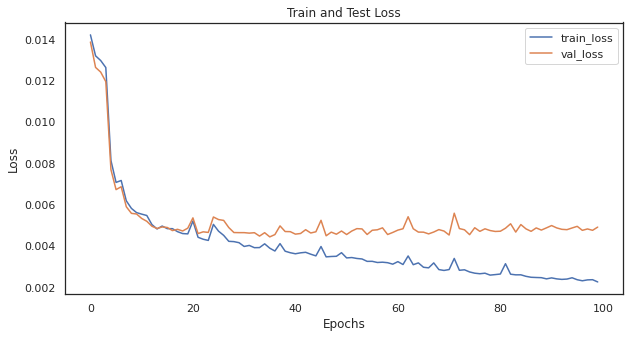

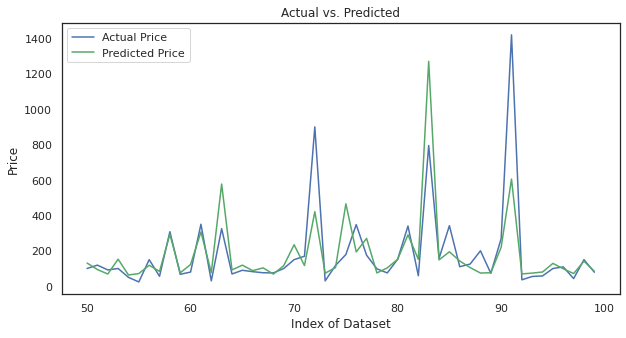

In [53]:
pd.DataFrame(history4).plot(figsize=(10,5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss")
plt.show()

def predict_single(x, model4):
    xb = x.unsqueeze(0)
    return model4(x).item()

# Predicting on 50 datapoints
tar = []
pre = []
for i in range(50, 100):
    x, target = val_ds[i]
    pred = predict_single(x, model4)
    # print("Input: ", x)
    data = scaler.inverse_transform(np.array([target.item(), pred]).reshape(-1, 1)).tolist()
    tar.append(data[0][0])
    pre.append(data[1][0])

x_axis = np.arange(50, 100, 1)
plt.figure(figsize=(10, 5))
plt.xlabel("Index of Dataset")
plt.ylabel("Price")
plt.title("Actual vs. Predicted")
plt.plot(x_axis, tar, 'b', label="Actual Price")
plt.plot(x_axis, pre, 'g', label="Predicted Price")
plt.legend()
plt.show()